In [9]:
from google.colab import files
uploaded = files.upload()

Saving train_1.csv to train_1.csv


In [86]:
import pandas as pd
import numpy as np
import pylab as p
import matplotlib.pyplot as plot
from collections import Counter
import re

data=pd.read_csv ("train_1.csv")

data.info()
data.describe()
n=data.isnull().sum()
data_no_null=data.fillna(0)
#print(data_no_null.head())
print("done")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145063 entries, 0 to 145062
Columns: 551 entries, Page to 2016-12-31
dtypes: float64(550), object(1)
memory usage: 609.8+ MB
done


In [87]:
import re
def language_abb(page): 
    res = re.search('[a-z][a-z].wikipedia.org',page) 
    if res: 
        return res.group(0)[0:2] 
    return 'na'

data['lang'] = data.Page.map(language_abb)
data["lang"]= data["lang"].replace(["en","ja",'de','na','fr','zh','ru','es'], ["English","Japanese",'German','WikiMedia','French','Chinese','Russian','Spanish'])

lang_count=data['lang'].value_counts()

lang_count

print("done")

done


In [0]:
# Grouping dataframe langauge wise
name=["en","ja",'de','na','fr','zh','ru','es']
full_name=["English","Japanese",'German','WikiMedia','French','Chinese','Russian','Spanish']
lang_sets={}
for x in range(0,8):
    lang_sets[name[x]] = data[data.lang==full_name[x]].iloc[:,0:-1]
# Removing the page names
for index in lang_sets:
    lang_sets[index]=lang_sets[index].drop(columns=['Page'])

In [0]:
null_num={}
t_sum={}
mean={}
meanperDay={}


for index in lang_sets:
    null_num[index]=lang_sets[index].isnull().sum()
    t_sum[index]=null_num[index].sum(axis=0)/550
    mean[index]=lang_sets[index].mean().mean()

In [0]:
# Dealing with Null Values
for index in lang_sets:
    lang_sets[index]=lang_sets[index].fillna(0)
                                             
# Summing for different langues/ reshaping the input data
sum_col ={}

for index in lang_sets:
    sum_col[index]=lang_sets[index].sum(axis=0) / lang_sets[index].shape[0]

In [92]:
# Extracting data according to the language given in the input

import math as math

def extract_language(df):
    #size = int(len(df)-50)
    #train_ds, test_ds = df[0:size], df[size:len(df)]
    df_train = pd.DataFrame({ 'Date':(df.index),'Hits': (df.values)})
    #df_test = pd.DataFrame({ 'Date':(test_ds.index),'Hits': (test_ds.values)})
    
    
    return df_train

X_train = extract_language(sum_col["en"])# Change this one by on

#print("The training set sample:")
print(X_train.head())
#print("The validation set sample:")
#print(y_train.head())

         Date         Hits
0  2015-07-01  3513.862203
1  2015-07-02  3502.511407
2  2015-07-03  3325.357889
3  2015-07-04  3462.054256
4  2015-07-05  3575.520035


In [0]:
def timeseries_to_supervised(data, lag=1):
	df = pd.DataFrame(data)
	columns = [df.shift(i) for i in range(1, lag+1)]
	columns.append(df)
	df = pd.concat(columns, axis=1)
	df.fillna(0, inplace=True)
	return df


In [191]:
def fit_lstm(X_train,y_train,batch_size, nb_epoch, neurons):
	#X, y = train[:, 0:-1], train[:, -1]

  n=2
  func =  'softmax'
  X_train = X_train.reshape(X_train.shape[0],1,X_train.shape[1])
  model = Sequential()
  model.add(LSTM(neurons, batch_input_shape=(batch_size, X_train.shape[1], X_train.shape[2]), stateful=True))
  model.add(Dense(n,activation=func))
  model.add(Dense(n,activation=func))
  model.add(Dense(n,activation=func))
  model.add(Dense(n,activation=func))


  model.add(Dense(1))
  model.compile(loss='mean_squared_error',optimizer = 'adam')
  for i in range(nb_epoch):
    print("nb_epochs = ",i)
    model.fit(X_train,y_train,epochs=1,batch_size = batch_size , verbose =0,shuffle=False)
    model.reset_states()

  return model  
print("done")

done


In [95]:
#scaler = MinMaxScaler(feature_range=(-1, 1))
def scaling_windowing(df_train,window_size):
  from sklearn.preprocessing import StandardScaler,MinMaxScaler  
  scaler = MinMaxScaler(feature_range=(-1, 1))
  df_supervised = timeseries_to_supervised(df_train['Hits'].values,window_size)
  train_data = df_supervised[0:500].values
  test_data = df_supervised[500:550].values
  print(df_supervised.shape)

  train_data_scaled = scaler.fit_transform(train_data)  
  test_data_scaled = scaler.fit_transform(test_data)
  X_train,y_train = train_data_scaled[:,0:window_size] , train_data_scaled[:,window_size: window_size+1]
  X_test,y_test = test_data_scaled[:,0:window_size] , test_data_scaled[:,window_size:window_size+1]
 
  print("X_train.shape = ", X_train.shape)
  print("y_train.shape = ", y_train.shape)

  print("X_test.shape = ",X_test.shape)
  print("y_test.shape = ",y_test.shape)


  print("shape = ",df_supervised)
  return [X_train,y_train,X_test,y_test,train_data,test_data,scaler]

print("done")

done


In [0]:

import numpy as np

def forecast_lstm(model, batch_size, X):
	X = X.reshape(1, 1, len(X))
	yhat = model.predict(X, batch_size=batch_size)
	return yhat[0,0]




def invert_scale(scaler,X,value):
  new_row = [x for x in X] + [value]
  array = np.array(new_row)
  array = array.reshape(1,len(array))
  print("array.shape  = ",array.shape)
  inverted = scaler.inverse_transform(array)
  return inverted[0,-1]



  
def prediction(lstm_model,X_test,scaler):
  predictions = []
  for i in range(len(X_test)):
      X = X_test[i,:] 
      y_knot = forecast_lstm(lstm_model,1,X)
      y_pred = invert_scale(scaler,X,y_knot)
      predictions.append(y_pred)
  return predictions
  


In [0]:

def plot_graphs(y_pred,y_actual):
  import matplotlib.pyplot as plt
  y_actual = list(y_actual)
  plt.figure(figsize=(8, 6))
  time = [x for x in range(0,len(y_actual))]
  labels={'Orginal','Predicted'}
  plt.plot(time, y_actual, color= 'green')
  plt.plot(time,y_pred, color = 'orange')
  plt.title('Actual Vs Forecast- LSTM')
  plt.xlabel('Days')
  plt.ylabel('Hits')
  plt.legend(labels)
  plt.show()
  
def print_side_by_side(y_pred,y_actual):
    for i in range(0,len(y_pred)):
      print(y_pred[i], " , ", y_actual[i])

In [0]:
error_rmse=[]
error_log_mse=[]
error_pd=[]

df_train =           Date        Hits
0  2015-07-01  580.647056
1  2015-07-02  666.672801
2  2015-07-03  602.289805
3  2015-07-04  756.509177
4  2015-07-05  725.720914
(550, 5)
X_train.shape =  (500, 4)
y_train.shape =  (500, 1)
X_test.shape =  (50, 4)
y_test.shape =  (50, 1)
shape =                0           0           0           0            0
0      0.000000    0.000000    0.000000    0.000000   580.647056
1    580.647056    0.000000    0.000000    0.000000   666.672801
2    666.672801  580.647056    0.000000    0.000000   602.289805
3    602.289805  666.672801  580.647056    0.000000   756.509177
4    756.509177  602.289805  666.672801  580.647056   725.720914
5    725.720914  756.509177  602.289805  666.672801   632.399148
6    632.399148  725.720914  756.509177  602.289805   615.184181
7    615.184181  632.399148  725.720914  756.509177   611.462337
8    611.462337  615.184181  632.399148  725.720914   596.067642
9    596.067642  611.462337  615.184181  632.399148   619.299300

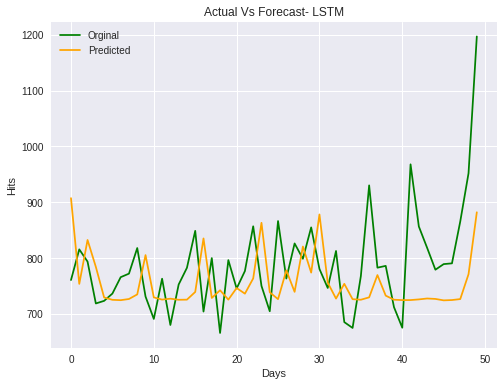

Test RMSE: 97.977
Test log-MSE: 9.169
Percentage difference: 9.281


In [192]:
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
from sklearn.metrics import mean_squared_error

window_size = 4

nb=[200]
df_train = extract_language(sum_col["ja"])
print("df_train = ",df_train.head())


def percentage_diff(y_p,y_a):
  error=0
  for i in range(0,len(y_a)):
    error = (error + (float(abs (y_p[i] - y_a [i])) / float(y_a[i]) * 100 ) )
  error = error/ len(y_a)
  return error


for i in range(0,len(nb)):
  
    [X_train,y_train,X_test,y_test,train_data,test_data,scaler]=scaling_windowing(df_train,window_size)
    lstm_model = fit_lstm(X_train,y_train, 1,nb[i], 4)
    y_pred = prediction(lstm_model,X_test,scaler)
    y_actual= list(test_data[:,window_size : window_size+1])
    print_side_by_side(y_pred,y_actual)
    plot_graphs(y_pred,y_actual)
    rmse = sqrt(mean_squared_error(y_actual,y_pred))
    log_mse = np.log(np.array(mean_squared_error(y_actual,y_pred)))
    pdiff = percentage_diff(y_pred,y_actual)
    print('Test RMSE: %.3f' % rmse)
    print('Test log-MSE: %.3f' % log_mse)
    print('Percentage difference: %.3f' % pdiff)
    error_rmse.append(rmse)
    error_log_mse.append(log_mse)
    error_pd.append(pdiff)




In [0]:
funcc=['tanh','sigmoid','relu','softmax']


In [0]:
8.279

<BarContainer object of 4 artists>

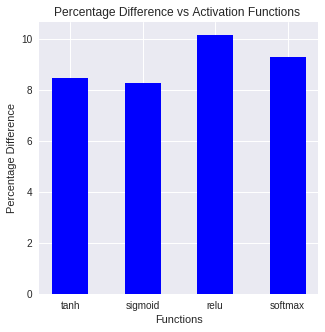

In [195]:
nb=[1,2,3,4,5,6,7,8]


fig = plot.figure(1,figsize=[5,5])
plot.ylabel('Percentage Difference')
plot.xlabel('Functions')
plot.title('Percentage Difference vs Activation Functions ')
plot.bar(funcc,error_pd,width=0.5,color='b')

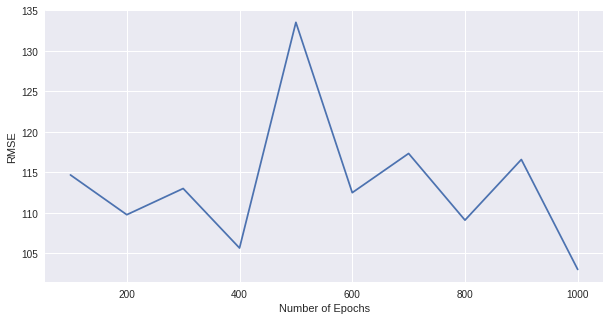

In [106]:
fig = plot.figure(1,figsize=[10,5])
plot.ylabel('RMSE')
plot.xlabel('Number of Epochs')
plot.plot(nb[2:len(nb)],error_rmse[2:len(nb)])
  

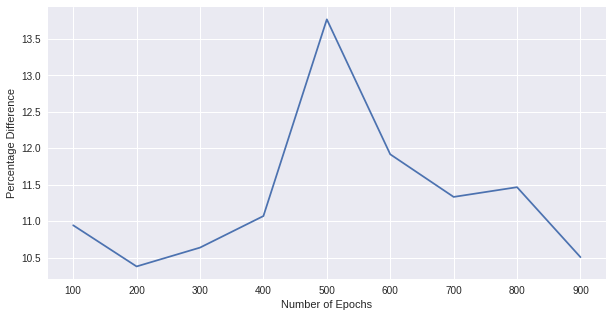

In [110]:
fig = plot.figure(1,figsize=[10,5])
plot.ylabel('Percentage Difference')
plot.xlabel('Number of Epochs')
plot.plot(nb[2:len(nb)-1],error_pd[2:len(nb)-1])
  

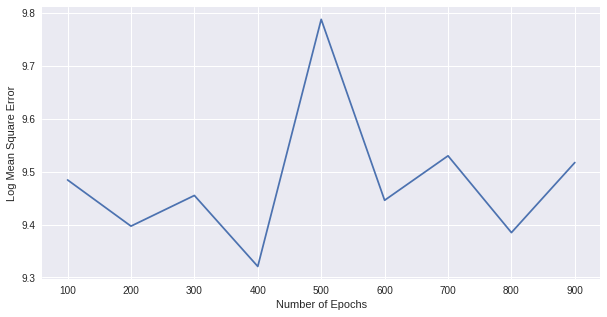

In [112]:


fig = plot.figure(1,figsize=[10,5])
plot.ylabel('Log Mean Square Error')
plot.xlabel('Number of Epochs')
plot.plot(nb[2:len(nb)-1],error_log_mse[2:len(nb)-1] )